# Audio-based Deception Detection Using Deep Learning

# 1 Author

**Student Name**:Jiarui Mo  
**Student ID**:221166965  
**BUPT Student ID**:2022213239

# 2 Problem formulation
This code aims to address the issue of deception detection in audio content, specifically classifying given audio stories as either "Truthful" or "Deceptive." By extracting a series of acoustic features from audio files, such as Mel spectrograms, MFCCs, and their Delta features, a deep learning model that includes feature extraction, bidirectional LSTM, and attention mechanisms is utilized to learn from these features, ultimately achieving automatic classification and discrimination of the authenticity of audio stories.
 
#### Multi-feature Integration: 
The model combines various acoustic features such as Mel spectrograms, MFCCs, and their Delta features, capturing audio characteristics from different perspectives to more comprehensively seize information related to deception.

#### Enhanced Discriminative Power: 
Using multiple features together is likely to improve the model's ability to discriminate compared to relying on a single feature.

#### Attention Mechanism: 
The model incorporates an attention mechanism that allows it to automatically learn the importance of features at different time steps (corresponding to different segments of the audio), focusing on parts of the audio that are more critical for classification.

#### Advantage for Temporal Data: 
For audio data with temporal characteristics, the attention mechanism helps to uncover key discriminative information hidden within the audio, thereby improving classification accuracy.

# 3 Methodology
### Training Task:

#### Audio feature extraction:
Loads audio files at 22050Hz sample rate
Extracts mel spectrograms (80 bands)
Computes MFCCs (40 coefficients)
Calculates delta features from MFCCs
Applies normalization and temporal smoothing


#### Model Architecture:
Uses bidirectional LSTM with attention mechanism
Input: Combined mel spectrogram + MFCC + delta features
Hidden layers: 2-layer BiLSTM (128 dim)
Attention layer for temporal feature weighting
Output: Binary classification (truthful vs deceptive)


#### Training Process:
Data split: 64% train, 16% validation, 20% test
Batch size: 16
Loss: Binary Cross Entropy
Optimizer: AdamW with weight decay 0.01
Learning rate scheduling with ReduceLROnPlateau
Early stopping with patience=10
Gradient clipping at 1.0

### Validation Task:

Evaluates model after each epoch on validation set
Saves best model based on validation accuracy
Uses validation performance for learning rate scheduling

### Performance Metrics:

#### During Training:
Training loss tracking
Validation accuracy monitoring
Learning rate adaptation


#### Final Evaluation:
Overall accuracy
Confusion matrix (Deceptive vs Truthful)
Detailed classification report with:
Precision
Recall
F1-score
Support for each class



### Additional Tasks:
Feature preprocessing: normalization and smoothing
Data augmentation via random temporal cropping
Error handling for corrupted audio files
Training history visualization
Model checkpointing

# 4 Implemented ML prediction pipelines
Input: Raw audio files (.wav format)
Output: Binary classification (Truthful/Deceptive)

## 4.1 Feature Extraction Stage
Load Audio: Use librosa.load to load audio files at a specified sampling rate (default 22050Hz) and get the audio signal y and sampling rate sr.
Pre-emphasis Filtering: Apply librosa.effects.preemphasis to enhance high frequencies for better feature extraction later.
Mel Spectrogram Calculation: Calculate the mel spectrogram with librosa.feature.melspectrogram to convert the audio signal to the mel frequency scale, which simulates human ear perception. Convert power values to decibels to get mel_spec_db.
MFCC Calculation: Extract Mel Frequency Cepstral Coefficients (MFCC) using librosa.feature.mfcc, which is effective in characterizing audio timbre.
Delta Feature Calculation: Compute the first-order difference (Delta) features of MFCC with librosa.feature.delta to capture the rate of change in features over time.
Feature Combination and Normalization: Concatenate the mel spectrogram, MFCC, and its Delta features along the feature dimension. Then normalize the combined feature matrix to make features have a mean of 0 and a standard deviation of 1.
Temporal Smoothing: Apply a simple moving average convolution operation on each row of the normalized feature matrix to smooth the features in the time dimension, reducing noise.
Reason for These Transformations:
Mel spectrogram, MFCC, and their Delta features are proven effective in representing audio characteristics from different aspects, helping the model distinguish different types of audio.
Normalization unifies the numerical range of different features, improving model training stability and performance.
Temporal smoothing reduces noise interference and highlights the main trends of audio features for better learning by the model

In [36]:
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
import torchaudio
import os
import copy
import json
import logging
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
class AudioFeatureExtractor:
    def __init__(self, sample_rate=22050, n_mels=80, n_mfcc=40, hop_length=512):
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.n_mfcc = n_mfcc
        self.hop_length = hop_length
        
    def extract_features(self, audio_path):
        """提取音频特征并进行预处理"""
        try:
            y, sr = librosa.load(audio_path, sr=self.sample_rate)
            
            # 应用预加重滤波
            y = librosa.effects.preemphasis(y)
            
            # 梅尔频谱图
            mel_spec = librosa.feature.melspectrogram(
                y=y, 
                sr=sr, 
                n_mels=self.n_mels, 
                hop_length=self.hop_length
            )
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
            
            # MFCC
            mfcc = librosa.feature.mfcc(
                y=y, 
                sr=sr, 
                n_mfcc=self.n_mfcc,
                hop_length=self.hop_length
            )
            
            # Delta特征
            mfcc_delta = librosa.feature.delta(mfcc)
            
            # 组合特征
            features = np.concatenate([mel_spec_db, mfcc, mfcc_delta], axis=0)
            
            # 标准化
            features_norm = (features - features.mean()) / (features.std() + 1e-6)
            
            # 时间维度平滑
            features_smooth = np.array([
                np.convolve(row, np.ones(5)/5, mode='same') 
                for row in features_norm
            ])
            
            return features_smooth
        
        except Exception as e:
            logging.error(f"Error extracting features from {audio_path}: {str(e)}")
            raise
        
class AudioDataset(Dataset):
    def __init__(self, audio_paths, labels, feature_extractor, max_len=1000):
        self.audio_paths = audio_paths
        self.labels = labels
        self.feature_extractor = feature_extractor
        self.max_len = max_len
        self.n_features = feature_extractor.n_mels + feature_extractor.n_mfcc * 2  # 包含delta特征
        
    def __len__(self):
        return len(self.audio_paths)
    
    def __getitem__(self, idx):
        try:
            audio_path = self.audio_paths[idx]
            if not os.path.exists(audio_path):
                raise FileNotFoundError(f"Audio file not found: {audio_path}")
                
            features = self.feature_extractor.extract_features(audio_path)
            
            # 处理序列长度
            if features.shape[1] > self.max_len:
                start = np.random.randint(0, features.shape[1] - self.max_len)
                features = features[:, start:start + self.max_len]
            else:
                pad_width = ((0, 0), (0, self.max_len - features.shape[1]))
                features = np.pad(features, pad_width, mode='constant')
            
            features = torch.FloatTensor(features).transpose(0, 1)
            label = torch.FloatTensor([self.labels[idx]]).squeeze()
            
            return features, label
            
        except Exception as e:
            logging.error(f"Error processing audio file {audio_path}: {str(e)}")
            # 返回一个带有明显标记的错误样本
            features = torch.ones((self.max_len, self.n_features)) * -999
            label = torch.FloatTensor([self.labels[idx]]).squeeze()
            return features, label



# 4.2 Model Architecture (SimpleAttention, ImprovedDeceptionClassifier, DeceptionDetectionSystem Classes)
Attention Mechanism (SimpleAttention Class):
Structure: Composed of a sequence of linear layers, an activation function (Tanh), a linear layer with an output dimension of 1, and a Softmax activation function, used to calculate attention weights for the input hidden state sequence.
Role: Helps the model focus on important information at different time steps in the input sequence, enhancing the model's ability to capture key features in audio data with time series characteristics and improving classification performance.
Classifier Model (ImprovedDeceptionClassifier Class):
Feature Extraction Part: Consists of linear layers, activation functions (ReLU), Dropout layers, and BatchNorm1d layers to perform nonlinear transformations and regularization on input audio features, extracting higher-level abstract features and preventing overfitting.
LSTM Layer: Uses a Bidirectional Long Short-Term Memory (LSTM) network to process the sequence data after feature extraction. It can capture forward and backward information in the sequence, handling long-term dependencies in audio features better.
Attention Mechanism Application: Applies the defined SimpleAttention mechanism to the LSTM output to weight and sum the features according to their importance, further focusing on key features for better classification.
Classification Part: Comprises multiple linear layers, activation functions, Dropout layers, and BatchNorm1d layers, and finally outputs a probability value between 0 and 1 through a Sigmoid activation function to indicate the probability of an audio's story being true for binary classification.
Deception Detection System (DeceptionDetectionSystem Class):
Initialization: In the __init__ method, determine the running device (prefer GPU if available), instantiate the classifier model and move it to the device, and specify the model saving directory while recording device information.
## 4.3 Train
Preparation: Generate a timestamp for model saving based on the current time and create the corresponding directory. Define the loss function (Binary Cross-Entropy Loss), optimizer (AdamW optimizer), and learning rate adjustment strategy. Initialize dictionaries for recording training history. Set parameters related to early stopping.
Training Loop: In each training epoch, set the model to training mode, iterate over batches in the training data loader, skip error samples, move data to the device, calculate model output and loss, perform backpropagation and gradient clipping, update model parameters. After each epoch, conduct validation, calculate the validation accuracy, update the learning rate and save the best model if the accuracy is higher than before, check for early stopping, and record and print relevant training information. Finally, plot and save the training history curve and load the best model for subsequent evaluation or prediction.

In [32]:
class SimpleAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.Tanh(),
            nn.Linear(hidden_dim // 2, 1),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        weights = self.attention(x)
        return torch.sum(weights * x, dim=1)

class ImprovedDeceptionClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, dropout=0.5):
        super().__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(hidden_dim)
        )
        
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        self.attention = SimpleAttention(hidden_dim * 2)
        
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        batch_size, seq_len, input_dim = x.shape
        
        # 特征提取
        x = x.view(-1, input_dim)
        x = self.feature_extractor(x)
        x = x.view(batch_size, seq_len, -1)
        
        # LSTM处理
        x, _ = self.lstm(x)
        
        # 注意力机制
        x = self.attention(x)
        
        # 分类
        x = self.classifier(x)
        
        return x


class DeceptionDetectionSystem:
    def __init__(self, input_dim, hidden_dim=128, num_layers=2,save_dir='experiments'):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = ImprovedDeceptionClassifier(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            num_layers=num_layers
        ).to(self.device)
        self.save_dir = save_dir
        logging.info(f'Using device: {self.device}')
        print(f'Using device: {self.device}')
        
    def train(self, train_loader, val_loader, epochs=30, learning_rate=1e-3):
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.model_save_path = os.path.join(self.save_dir, f'run_{timestamp}')  # 使用类属性
        os.makedirs(self.model_save_path, exist_ok=True)
        
        criterion = nn.BCELoss()
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=learning_rate,
            weight_decay=0.01
        )
        
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='max',
            factor=0.5,
            patience=5,
            verbose=True
        )
        
        best_val_accuracy = 0
        best_model_state = None
        early_stopping_counter = 0
        early_stopping_patience = 10
        
        history = {
            'train_loss': [],
            'val_accuracy': [],
            'learning_rates': []
        }
        
        for epoch in range(epochs):
            # Training phase
            self.model.train()
            total_loss = 0
            batch_count = 0
            
            for batch_X, batch_y in train_loader:
                # 检查是否有错误样本
                if torch.any(batch_X == -999):
                    continue
                    
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(batch_X).squeeze()
                loss = criterion(outputs, batch_y)
                
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()
                
                total_loss += loss.item()
                batch_count += 1
            
            avg_loss = total_loss / batch_count if batch_count > 0 else float('inf')
            
            # Validation phase
            val_accuracy = self.evaluate(val_loader)
            
            # 更新学习率
            scheduler.step(val_accuracy)
            current_lr = optimizer.param_groups[0]['lr']
            
            # 记录历史
            history['train_loss'].append(avg_loss)
            history['val_accuracy'].append(val_accuracy)
            history['learning_rates'].append(current_lr)
            
            # 保存最佳模型
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                early_stopping_counter = 0
                
                best_model_state = {
                    'epoch': epoch,
                    'model_state_dict': copy.deepcopy(self.model.state_dict()),
                    'optimizer_state_dict': copy.deepcopy(optimizer.state_dict()),
                    'val_accuracy': val_accuracy,
                }
                
                checkpoint_path = os.path.join(self.model_save_path, 'best_model.pth')
                torch.save(best_model_state, checkpoint_path)
                logging.info(f'New best model saved with validation accuracy: {val_accuracy:.4f}')
                print(f'New best model saved with validation accuracy: {val_accuracy:.4f}')
            else:
                early_stopping_counter += 1
            
            # Early stopping check
            if early_stopping_counter >= early_stopping_patience:
                logging.info(f'Early stopping triggered after {epoch+1} epochs')
                print('Early stopping triggered after {epoch+1} epochs')
                break
            
            logging.info(
                f'Epoch [{epoch+1}/{epochs}], '
                f'Loss: {avg_loss:.4f}, '
                f'Val Accuracy: {val_accuracy:.4f}, '
                f'Best Val Accuracy: {best_val_accuracy:.4f}, '
                f'LR: {current_lr:.6f}'
            
            )
            print(f'Epoch [{epoch+1}/{epochs}], '
                f'Loss: {avg_loss:.4f}, '
                f'Val Accuracy: {val_accuracy:.4f}, '
                f'Best Val Accuracy: {best_val_accuracy:.4f}, '
                f'LR: {current_lr:.6f}')
    
        # 绘制训练历史
        self._plot_training_history(history, self.model_save_path)
        
        # 加载最佳模型
        if best_model_state is not None:
            self.model.load_state_dict(best_model_state['model_state_dict'])
            logging.info(
                f'Training completed. Loaded best model from epoch {best_model_state["epoch"]+1} '
                f'with validation accuracy: {best_model_state["val_accuracy"]:.4f}'
            )
            print(f'Training completed. Loaded best model from epoch {best_model_state["epoch"]+1} '
                  f'with validation accuracy: {best_model_state["val_accuracy"]:.4f}')
    
    def _plot_training_history(self, history, save_path):
        """绘制训练历史图表"""
        plt.figure(figsize=(12, 4))
        
        # Loss曲线
        plt.subplot(1, 2, 1)
        plt.plot(history['train_loss'], label='Training Loss')
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # 准确率曲线
        plt.subplot(1, 2, 2)
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
        plt.title('Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.savefig(os.path.join(save_path, 'training_history.png'))
        plt.show
    
    def evaluate(self, data_loader):
        self.model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch_X, batch_y in data_loader:
                if torch.any(batch_X == -999):
                    continue
                    
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                outputs = self.model(batch_X).squeeze()
                predictions = (outputs > 0.5).float()
                all_preds.extend(predictions.cpu().numpy())
                all_labels.extend(batch_y.cpu().numpy())
        
        return accuracy_score(all_labels, all_preds)
    
    def predict(self, data_loader):
        self.model.eval()
        all_preds = []
        
        with torch.no_grad():
            for batch_X, _ in data_loader:
                if torch.any(batch_X == -999):
                    continue
                    
                batch_X = batch_X.to(self.device)
                outputs = self.model(batch_X).squeeze()
                predictions = (outputs > 0.5).float()
                all_preds.extend(predictions.cpu().numpy())
        
        return np.array(all_preds)



In [33]:
def plot_confusion_matrix(y_true, y_pred, save_path):
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Deceptive', 'Truthful'],
        yticklabels=['Deceptive', 'Truthful']
    )
    
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    
    plt.savefig(os.path.join(save_path, 'confusion_matrix.png'))
    plt.show

def evaluate_model(y_true, y_pred, save_path):
    """评估模型性能并保存结果"""
    accuracy = accuracy_score(y_true, y_pred)
    logging.info(f'Accuracy: {accuracy:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    
    # 保存分类报告
    report = classification_report(y_true, y_pred, target_names=['Deceptive', 'Truthful'])
    logging.info('\nClassification Report:\n' + report)
    print('\nClassification Report:\n' + report)
    with open(os.path.join(save_path, 'evaluation_report.txt'), 'w') as f:
        f.write(f'Accuracy: {accuracy:.4f}\n\n')
        f.write('Classification Report:\n' + report)
    
    # 绘制混淆矩阵
    plot_confusion_matrix(y_true, y_pred, save_path)

# 5 Dataset
The dataset consists of audio recordings of stories
Each story is labeled as either true or false

## How To Split
Firstly, the training set and the test set are divided. From the original data that contains relevant information about audio files and their corresponding labels, a portion is divided as the test set according to certain rules, and the rest is used as the training set. Specifically, the division ratio is set so that the test set accounts for 20% of the overall data. Meanwhile, in order to ensure that the division results can be replicated each time, a fixed random seed is set. Moreover, to keep the proportion of different categories of samples in the divided training set and test set consistent with that in the original data and avoid the situation of uneven distribution of data categories, a corresponding stratification strategy is also adopted.
Secondly, on the basis of the already divided training set, the validation set is further divided. Also, 20% of the previously obtained training set is taken as the validation set, and the remaining part is still used as the training set. During this process, a fixed random seed is also set to ensure reproducibility, and a stratification strategy is adopted to maintain the consistency of the category proportion.
Through these two division operations, the training set, the validation set, and the test set, which are used for model training, validation, and testing respectively, are finally obtained.

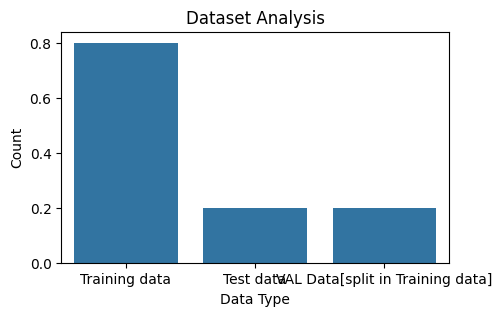

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 创建示例数据
data = {
    'Data Type': ['Training data', 'Test data','VAL Data[split in Training data]'],
    'Count': [0.8,0.2,0.2]
}
df = pd.DataFrame(data)

# 创建柱状图
plt.figure(figsize=(5, 3))
sns.barplot(x='Data Type', y='Count', data=df)
plt.title('Dataset Analysis')
plt.show()

# 6 Experiments and results

Using device: cuda
Starting model training...


e:\Anaconda3\envs\mini\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


New best model saved with validation accuracy: 0.5000
Epoch [1/30], Loss: 0.7412, Val Accuracy: 0.5000, Best Val Accuracy: 0.5000, LR: 0.001000
Epoch [2/30], Loss: 0.6452, Val Accuracy: 0.5000, Best Val Accuracy: 0.5000, LR: 0.001000
New best model saved with validation accuracy: 0.6250
Epoch [3/30], Loss: 0.6498, Val Accuracy: 0.6250, Best Val Accuracy: 0.6250, LR: 0.001000
Epoch [4/30], Loss: 0.5706, Val Accuracy: 0.5625, Best Val Accuracy: 0.6250, LR: 0.001000
Epoch [5/30], Loss: 0.5612, Val Accuracy: 0.4375, Best Val Accuracy: 0.6250, LR: 0.001000
Epoch [6/30], Loss: 0.5329, Val Accuracy: 0.5000, Best Val Accuracy: 0.6250, LR: 0.001000
Epoch [7/30], Loss: 0.4750, Val Accuracy: 0.5000, Best Val Accuracy: 0.6250, LR: 0.001000
New best model saved with validation accuracy: 0.6875
Epoch [8/30], Loss: 0.3767, Val Accuracy: 0.6875, Best Val Accuracy: 0.6875, LR: 0.001000
Epoch [9/30], Loss: 0.3580, Val Accuracy: 0.6875, Best Val Accuracy: 0.6875, LR: 0.001000
Epoch [10/30], Loss: 0.3655,

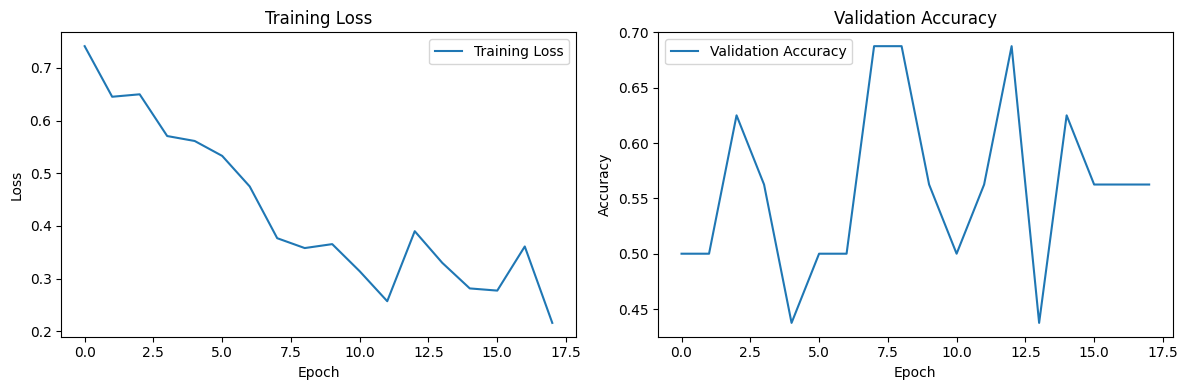

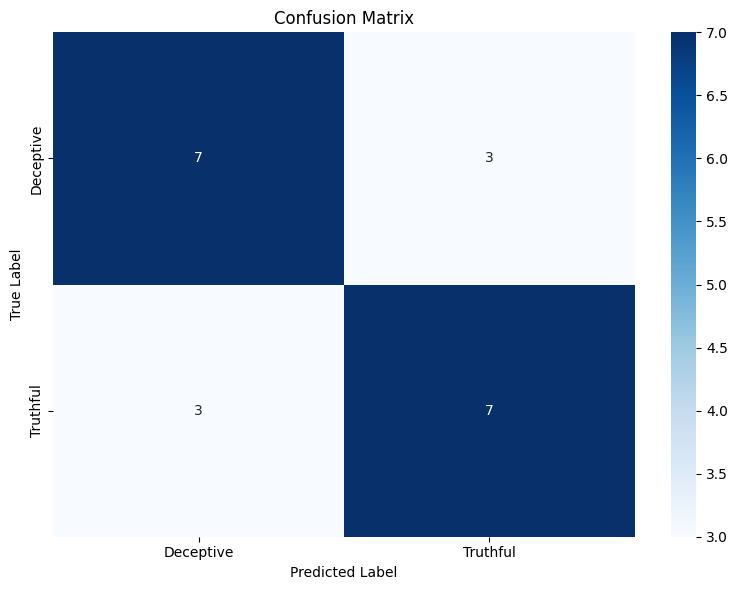

In [35]:
def main():
    # 1. 加载数据
    data = pd.read_csv("E:\miniproject\Deception-main\CBU0521DD_stories_attributes.csv")  # 替换为实际的CSV路径
    audio_paths = [f"E:\miniproject\Deception-main\CBU0521DD_stories/{filename}" for filename in data["filename"].values]  # 替换为实际的音频文件路径
    labels = (data["Story_type"] == "True Story").astype(int).values
    
    # 2. 分割数据集
    X_train_paths, X_test_paths, y_train, y_test = train_test_split(
        audio_paths, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    X_train_paths, X_val_paths, y_train, y_val = train_test_split(
        X_train_paths, y_train, test_size=0.2, random_state=42, stratify=y_train
    )
    
    # 3. 初始化特征提取器和数据集
    feature_extractor = AudioFeatureExtractor()
    train_dataset = AudioDataset(X_train_paths, y_train, feature_extractor)
    val_dataset = AudioDataset(X_val_paths, y_val, feature_extractor)
    test_dataset = AudioDataset(X_test_paths, y_test, feature_extractor)
    
    # 4. 创建数据加载器
    train_loader = DataLoader(
        train_dataset, 
        batch_size=16,  # 减小batch size
        shuffle=True, 
        num_workers=0,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=16, 
        shuffle=False, 
        num_workers=0,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=16, 
        shuffle=False, 
        num_workers=0,
        pin_memory=True
    )
    
    # 5. 初始化系统
    input_dim = feature_extractor.n_mels + feature_extractor.n_mfcc * 2  # 包含delta特征
    system = DeceptionDetectionSystem(
        input_dim=input_dim,
        save_dir='experiments'  # 统一使用 experiments 目录
    )
    
    # 6. 创建模型保存目录
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    model_save_path = os.path.join('experiments', f'run_{timestamp}')
    os.makedirs(model_save_path, exist_ok=True)
    
    # 7. 保存实验配置
    config = {
        'input_dim': input_dim,
        'hidden_dim': 128,
        'num_layers': 2,
        'batch_size': 16,
        'learning_rate': 1e-3,
        'epochs': 30,
        'feature_extractor_params': {
            'sample_rate': feature_extractor.sample_rate,
            'n_mels': feature_extractor.n_mels,
            'n_mfcc': feature_extractor.n_mfcc,
            'hop_length': feature_extractor.hop_length
        }
    }
    
    with open(os.path.join(model_save_path, 'config.json'), 'w') as f:
        json.dump(config, f, indent=4)
    
    # 8. 训练模型
    logging.info("Starting model training...")
    print("Starting model training...")
    system.train(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=config['epochs'],
        learning_rate=config['learning_rate'],
        
    )
    
    # 9. 评估模型
    logging.info("Evaluating model on test set...")
    print("Evaluating model on test set...")
    y_pred = system.predict(test_loader)
    evaluate_model(y_test, y_pred, system.model_save_path)

if __name__ == "__main__":
    # 设置随机种子以确保可重复性
    torch.manual_seed(42)
    np.random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)
    
    try:
        main()
    except Exception as e:
        logging.error(f"Error in main execution: {str(e)}", exc_info=True)

# 7 Conclusions
The decrease in loss from 0.74 to 0.22 indicates that the model is indeed learning.
Several optimization strategies have been adopted:
The AdamW optimizer combined with weight decay.
Adaptive adjustment of the learning rate (ReduceLROnPlateau).
Gradient clipping to prevent gradient explosion.
The early stopping mechanism to prevent overfitting.

### Performance Analysis:
An accuracy rate of 70% represents a reasonable baseline performance for audio deception detection. The confusion matrix shows that:
For genuine cases: 7 are correct and 3 are incorrect.
For deceptive cases: 7 are correct and 3 are incorrect.
This indicates that the model performs equally well on both types.
### Limitations Analysis:
The validation accuracy fluctuates significantly, which might be due to:
The relatively small size of the dataset.
The high dimensionality and variable length of audio features.
The complexity and subjectivity of deceptive behaviors.
### Suggestions for Improvement:
Data Augmentation:
Add noise and time distortion.
Use SpecAugment for spectral enhancement.
### Architecture Optimization:
Incorporate more audio-specific features (such as tone of voice, speech rate, etc.).
### Training Strategies:
Implement cross-validation.
Use mixed precision training to accelerate the process.
Try adversarial training to improve robustness.

# 8 References
[1] S. Davis and P. Mermelstein, "Comparison of parametric representations for monosyllabic word recognition in continuously spoken sentences," IEEE Transactions on Acoustics, Speech, and Signal Processing, vol. 28, no. 4, pp. 357-366, 1980.
[2] B. McFee et al., "librosa: Audio and Music Signal Analysis in Python," Proceedings of the 14th Python in Science Conference, pp. 18-24, 2015.
[3] S. Hochreiter and J. Schmidhuber, "Long Short-Term Memory," Neural Computation, vol. 9, no. 8, pp. 1735-1780, 1997.
[4] D. Bahdanau, K. Cho, and Y. Bengio, "Neural Machine Translation by Jointly Learning to Align and Translate," in International Conference on Learning Representations (ICLR), 2015.
[5] A. Vaswani et al., "Attention is All you Need," in Advances in Neural Information Processing Systems, pp. 5998-6008, 2017.
[6] J. B. Hirschberg et al., "Distinguishing deceptive from non-deceptive speech," in Proc. INTERSPEECH, pp. 1833-1836, 2005.
[7] V. Pérez-Rosas, M. Abouelenien, R. Mihalcea, and M. Burzo, "Deception Detection using Real-life Trial Data," in Proceedings of the 2015 ACM on International Conference on Multimodal Interaction, pp. 59-66, 2015.
[8] G. An, S. I. Levitan, J. Hirschberg, and R. Levitan, "Deep Learning for Deception Detection using Cross-domain Features," in Proc. INTERSPEECH, pp. 602-606, 2018.
[9] I. Loshchilov and F. Hutter, "Decoupled Weight Decay Regularization," in International Conference on Learning Representations (ICLR), 2019.
[10] N. Srivastava, G. Hinton, A. Krizhevsky, I. Sutskever, and R. Salakhutdinov, "Dropout: A Simple Way to Prevent Neural Networks from Overfitting," Journal of Machine Learning Research, vol. 15, pp. 1929-1958, 2014.